# Testing red noise as a null hypothesis in producing periodicity with 3 oscilations

### [Bahramian et al. 2017](http://adsabs.harvard.edu/abs/2017MNRAS.467.2199B)

### Simulating red noise using [Timmer & Koenig 1995](http://adsabs.harvard.edu/abs/1995A%26A...300..707T) method as implemented in [DELCgen](https://github.com/samconnolly/DELightcurveSimulation)  

In [1]:
import numpy as np
import scipy.stats as st
from astropy.io import fits,ascii
from astropy.time import Time
from DELCgen import *
from astroML.time_series import lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap, search_frequencies, MultiTermFit
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')

%matplotlib inline

## 1. Original data and power spectrum

peak at nu =  0.146172304811 /day, equivalent to a period of =  6.84124124124


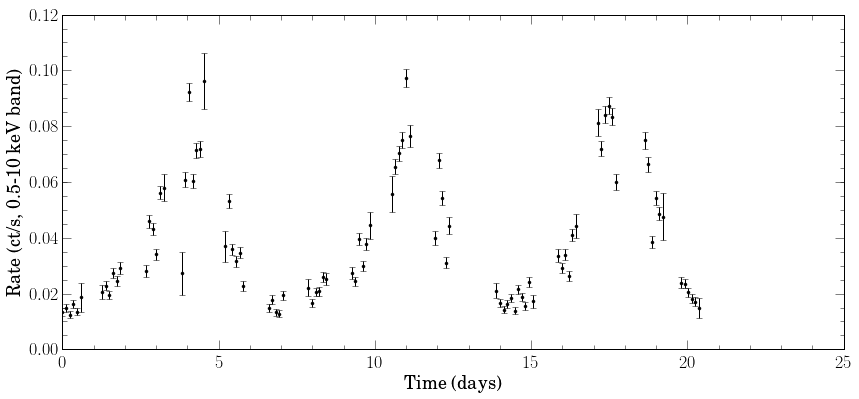

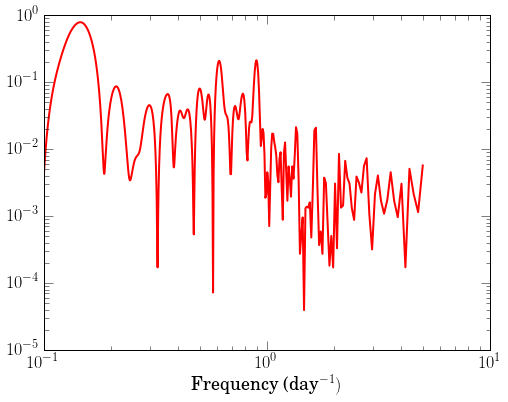

In [2]:
hrc_lc = fits.open('../chandra/HRC/X9_HRC_lc10ks_gti_filtered.fits')

x = (hrc_lc[1].data['Time']-hrc_lc[1].data['Time'][0])/(24*3600.0)
y = hrc_lc[1].data['NET_RATE']
y_er = hrc_lc[1].data['ERR_RATE']

plt.figure(figsize=(14,6))
plt.errorbar(x,y,y_er,fmt='.k')

plt.xlabel('Time (days)', fontsize=18)
plt.ylabel('Rate (ct/s, 0.5-10 keV band)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.ticklabel_format(axis='x',style='plain' ,useOffset=False)
plt.minorticks_on()

plt.figure(figsize=(8,6))
period = np.linspace(0.2, 10.0, 1000)
nu = 1/ period
omega = 2*np.pi/period
PS = lomb_scargle(x*(2*np.pi), y, y_er, nu, generalized=True)
plt.loglog(nu, PS,'-r', lw=2)
plt.xlabel(r'Frequency (day^{-1})', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.minorticks_on()
print 'peak at nu = ',nu[PS.argmax()],'/day, equivalent to a period of = ',1.0/nu[PS.argmax()]

** Note **: the range of period search in the periodograms through out this document is assumed $\leq10$ days, which is slightly above half the length of the entire lightcurve.

## 2. Simulating lightcurve based on observed data and a broken power law PSD

### Broken power law parameters:
$$ \Gamma_1 = 1.1 $$
$$ \Gamma_2 = 2.2 $$
$$ \nu_{break} = 0.146~day^{-1}$$
$\nu_{break}$ is based on the frequency of the peak in PSD of the data.

### Example of a simulated lightcurve:

In [3]:
lc = Lightcurve(x,y,10000./24./3600.0, y_er)
lc.STD_Estimate()

Fitting PSD for standard deviation estimation...


//anaconda/lib/python2.7/site-packages/DELCgen.py:361: RuntimeWarning: invalid value encountered in log
  p = 2.0 * np.sum( np.log(psd[:-1]) + (periodogram[1][:-1]/psd[:-1]) )
//anaconda/lib/python2.7/site-packages/DELCgen.py:237: RuntimeWarning: invalid value encountered in power
  denom = 1 + (v/v_bend)**(a_high-a_low)
//anaconda/lib/python2.7/site-packages/DELCgen.py:362: RuntimeWarning: invalid value encountered in log
  p_nq = np.log(np.pi * periodogram[1][-1]*psd[-1]) \
//anaconda/lib/python2.7/site-packages/DELCgen.py:237: RuntimeWarning: overflow encountered in power
  denom = 1 + (v/v_bend)**(a_high-a_low)
//anaconda/lib/python2.7/site-packages/DELCgen.py:237: RuntimeWarning: overflow encountered in double_scalars
  denom = 1 + (v/v_bend)**(a_high-a_low)


0.013556681039125204

Data: peak at nu =  0.146172304811 /day, P =  6.84124124124 , power= 0.786422719192
Simulation: peak at nu =  0.1 /day, P =  10.0 , power= 0.36423679573


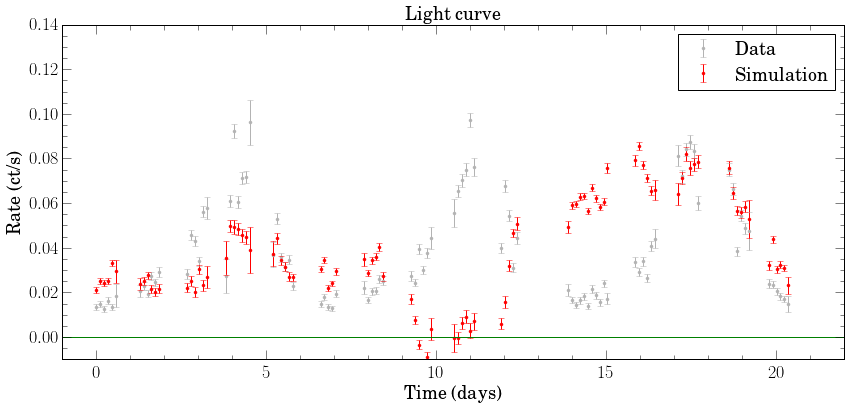

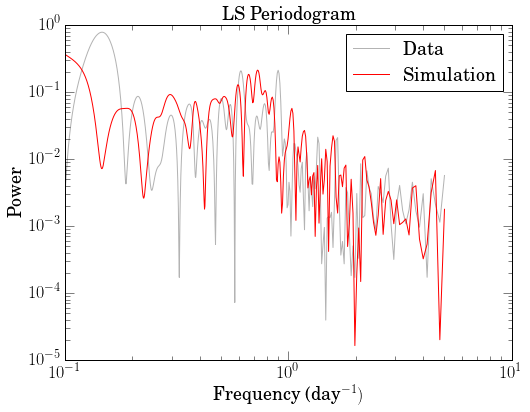

In [4]:
A,v_bend,a_low,a_high,c = 0.03, nu[PS.argmax()], 1.1, 2.2, 0 
tklc = Simulate_TK_Lightcurve(BendingPL,(A,v_bend,a_low,a_high,c), lightcurve=lc)
plt.figure(figsize=(14,6))
plt.title('Light curve', fontsize=18)
plt.errorbar(lc.time,lc.flux,lc.errors,fmt='.',color='0.7',label='Data')
plt.errorbar(tklc.time, tklc.flux,y_er, fmt='.r', label='Simulation')
plt.plot([-1,22],[0,0],'-g')
plt.xlabel('Time (days)', fontsize=18)
plt.ylabel('Rate (ct/s)', fontsize=18)
plt.xlim(-1,22)
plt.ylim(-0.01,0.14)
plt.legend(numpoints=1,fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.minorticks_on()

plt.figure(figsize=(8,6))
plt.title('LS Periodogram', fontsize=18)
period = np.linspace(0.2, 10.0, 1000)
nu = 1/ period
omega = 2*np.pi/period
PS = lomb_scargle(lc.time*(2*np.pi), lc.flux, lc.errors, nu, generalized=True)
print 'Data: peak at nu = ',nu[PS.argmax()],'/day, P = ',1.0/nu[PS.argmax()],', power=',PS[PS.argmax()]
plt.loglog(nu, PS,'-',color='0.7', label='Data')
PS = lomb_scargle(tklc.time*(2*np.pi), tklc.flux, lc.errors, nu, generalized=True)
print 'Simulation: peak at nu = ',nu[PS.argmax()],'/day, P = ',1.0/nu[PS.argmax()],', power=',PS[PS.argmax()]
plt.loglog(nu, PS,'-r', label='Simulation')
plt.legend(numpoints=1,fontsize=18)
plt.xlabel(r'Frequency (day^{-1})', fontsize=18)
plt.ylabel('Power', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.minorticks_on()

## 3. Mass simulations and probability estimation

In [5]:
# Scripting note: the simulation command is a bit buggy, occassionally crashes when simulating lightcurves.
# So I brute force ignoring the failed simulations.
high_pwr_lcs = []
max_pwr = []
ps_rand = []
i = 0
while i < 50000:
    try:
        tklc = Simulate_TK_Lightcurve(BendingPL,(A,v_bend,a_low,a_high,c), lightcurve=lc)
        i+=1
        PS = lomb_scargle(tklc.time*(2*np.pi), tklc.flux, lc.errors, nu, generalized=True)
        ps_rand.append(PS)
        max_pwr.append(max(PS))
        if max(PS) >= 0.79:
            high_pwr_lcs.append(tklc)
    except:
        pass
print 'Number of Generated lightcurves:', len(max_pwr)

Number of Generated lightcurves: 50000


sample size: 50000
Number of LCs with peak power of 0.79 or higher: 35
probability of getting a peak power of 0.79 or higher by chance: 0.07 %


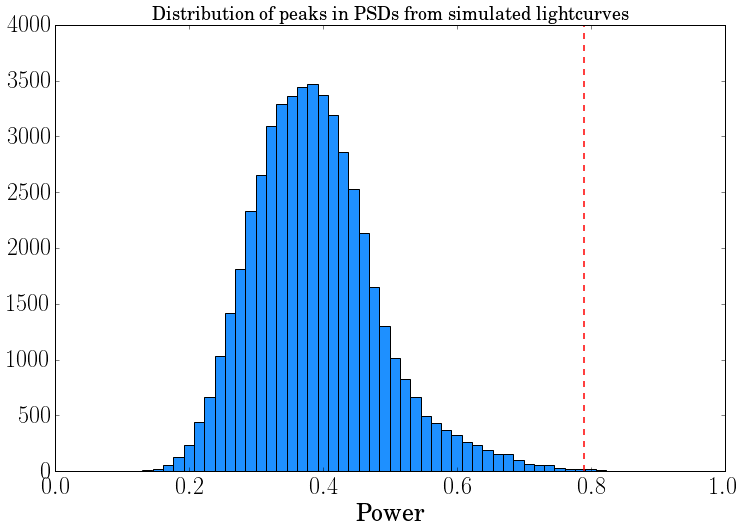

In [6]:
plt.figure(figsize=(12,8))
plt.title('Distribution of peaks in PSDs from simulated lightcurves', fontsize=18)
plt.hist(max_pwr,bins=50,color='dodgerblue',normed=False)
plt.plot([0.79,0.79],[0,5000],'--r',lw=1.5)
plt.xlim(0.0,1.0)
plt.ylim(0,4000)
plt.xlabel(r'Power',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
p = 0
for i in max_pwr:
    if i >= 0.79:
        p+=1

print 'sample size:', len(max_pwr)
print 'Number of LCs with peak power of 0.79 or higher:', p
print 'probability of getting a peak power of 0.79 or higher by chance:', 100*float(p)/len(max_pwr),'%'

The red dashed line shows the peak in PSD of the data.

## 4. Sample power spectra from the simulations

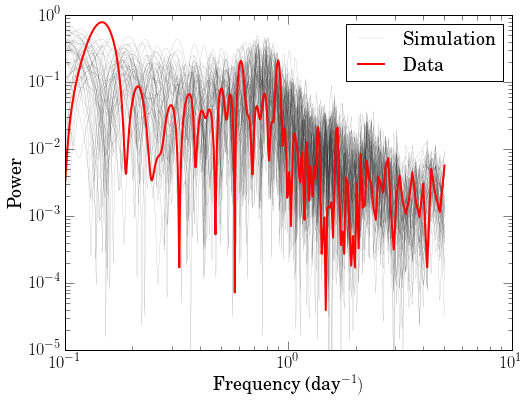

In [7]:
plt.figure(figsize=(8,6))

for i in range(len(ps_rand[::1000])):
    plt.loglog(nu, ps_rand[i],'-', color='0.2',lw=0.1)

plt.loglog(nu, ps_rand[-1],'-', color='0.2',lw=0.1, label='Simulation')
    
PS = lomb_scargle(lc.time*(2*np.pi), lc.flux, lc.errors, nu, generalized=True)
plt.loglog(nu, PS,'-r',lw=2, label='Data')
plt.legend(fontsize=18)
plt.ylim(1e-5,1)
plt.xlabel(r'Frequency (day^{-1})', fontsize=18)
plt.ylabel('Power', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.minorticks_on()

In the figure above, red line shows the power spectrum for the data and the gray lines show results for a random subset of the simulated light curves.

## 5. Simulated light curves with peak power similar to (or higher than) that of our data:

Total number of simulated lightcurves: 50000
Number of simulated lightcurves with peak power equal or greater than 0.79: 35


//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


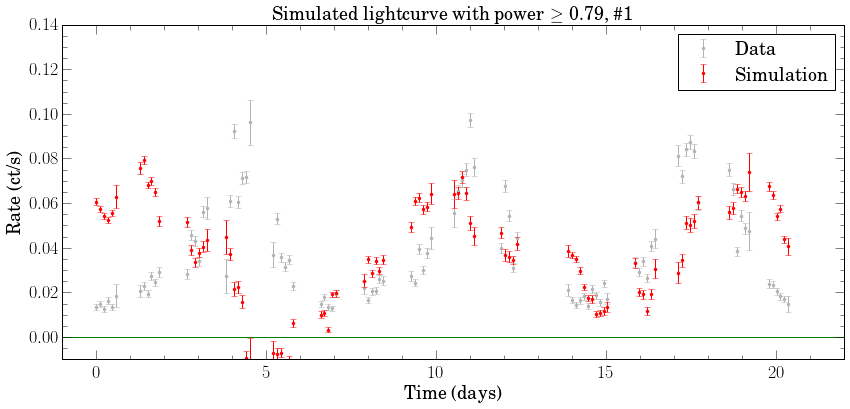

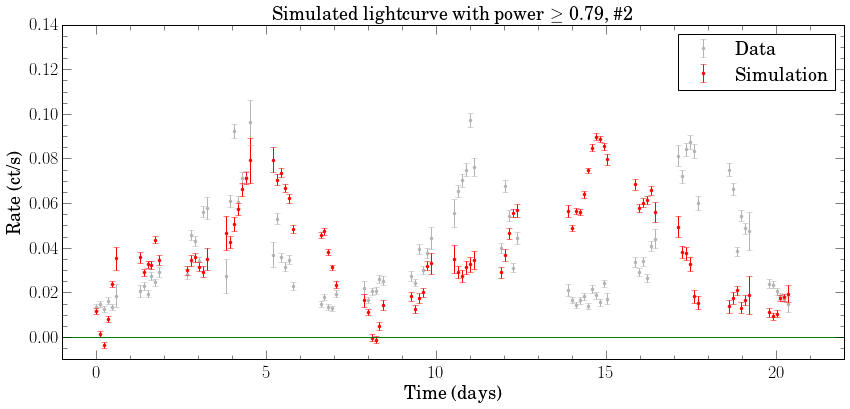

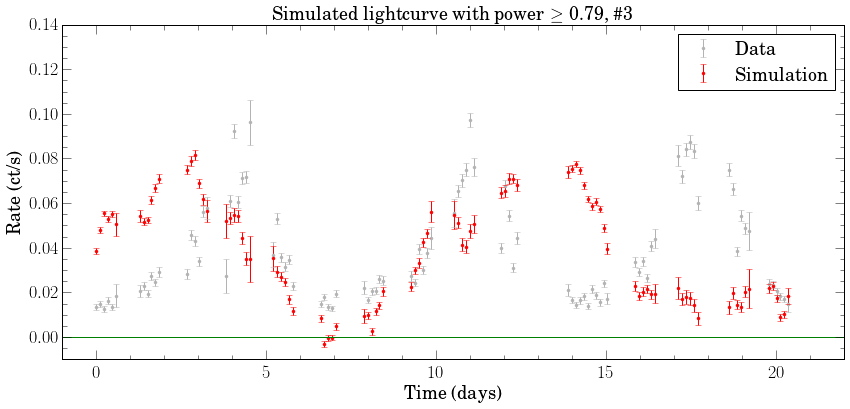

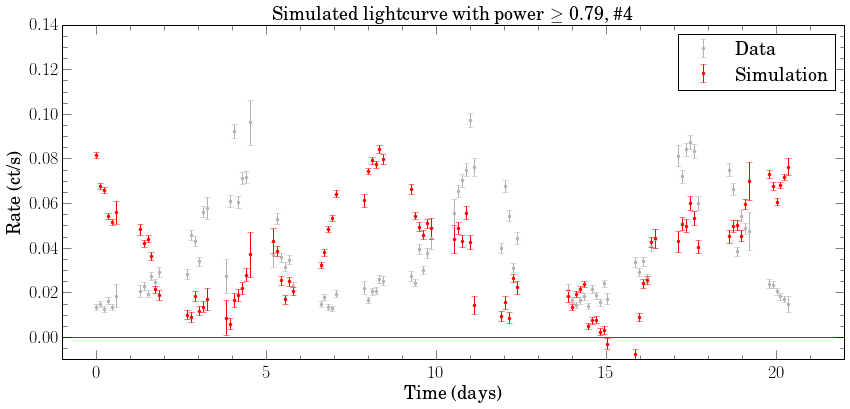

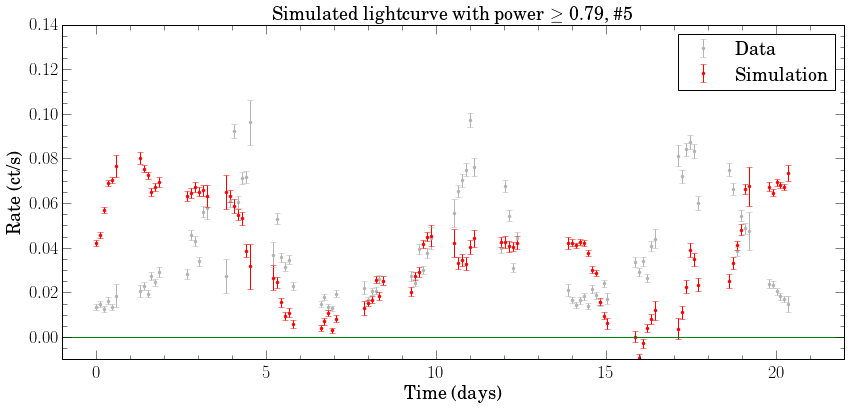

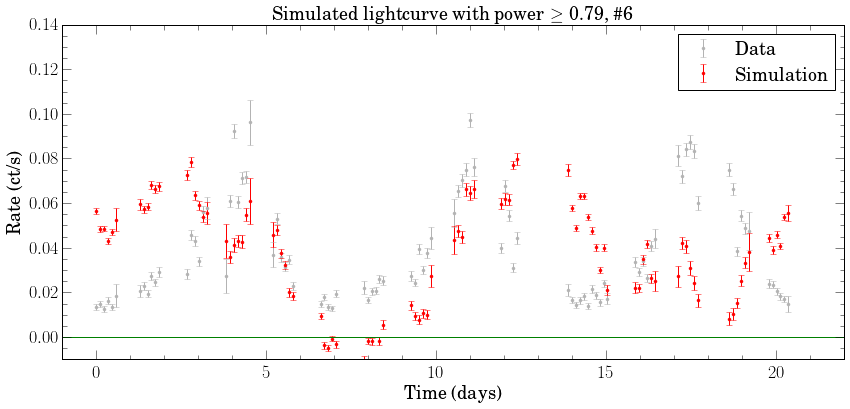

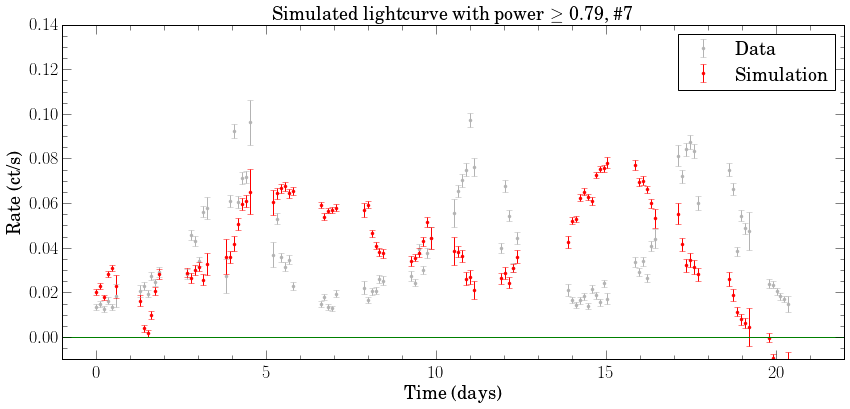

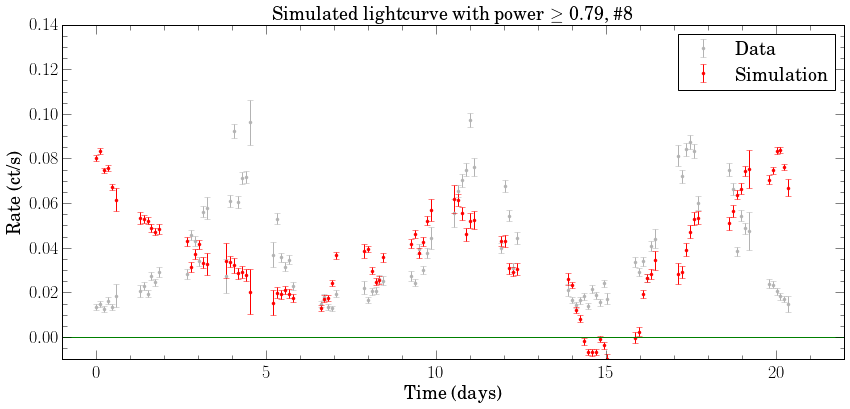

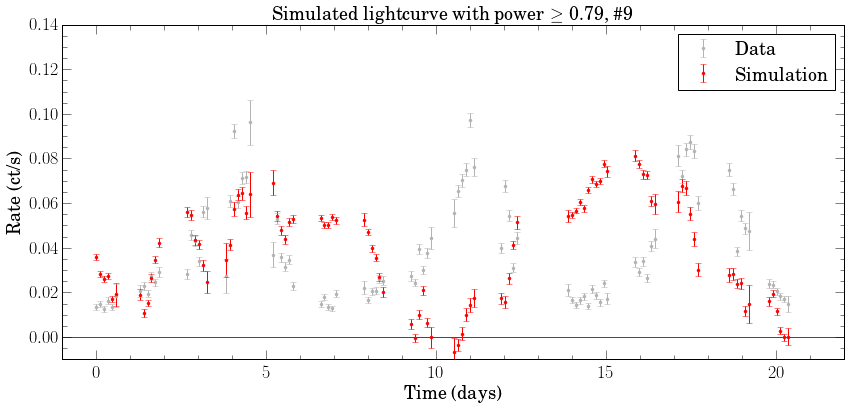

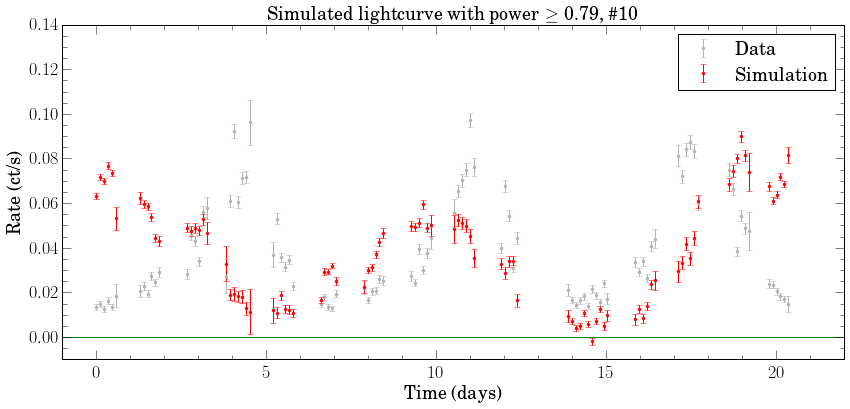

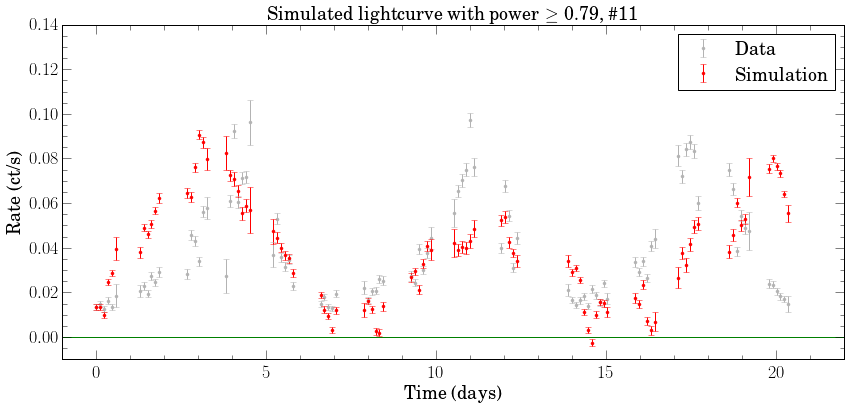

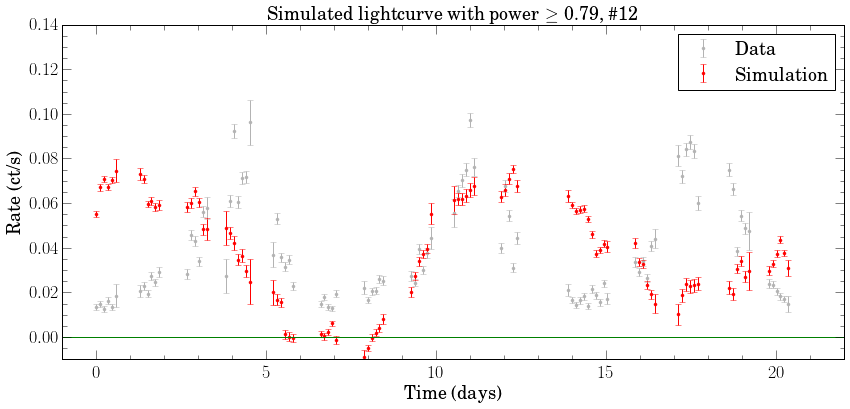

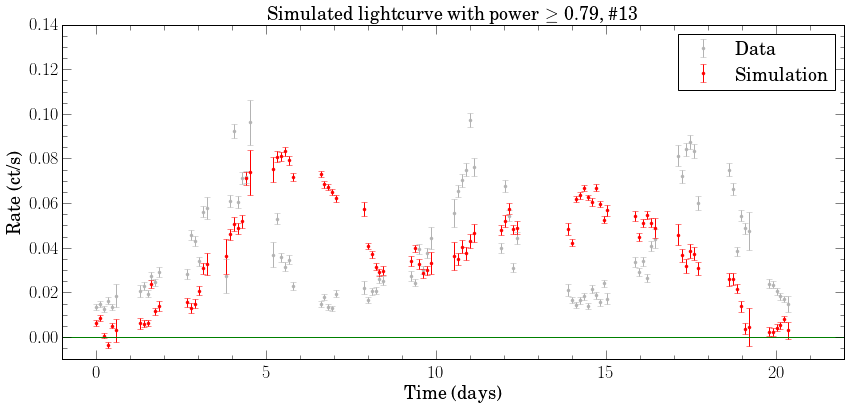

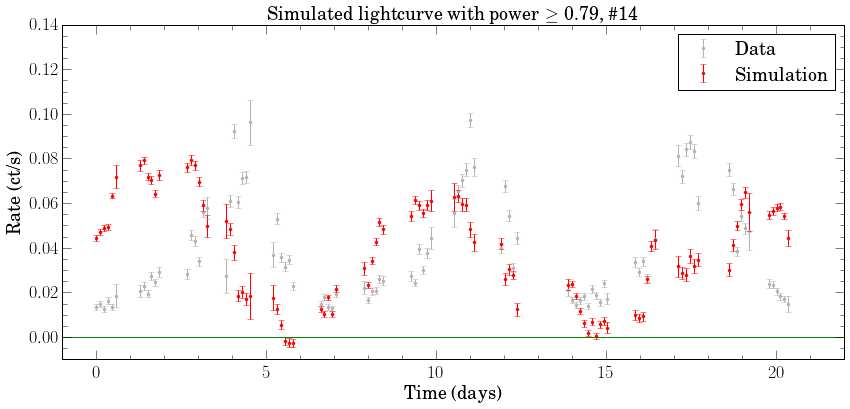

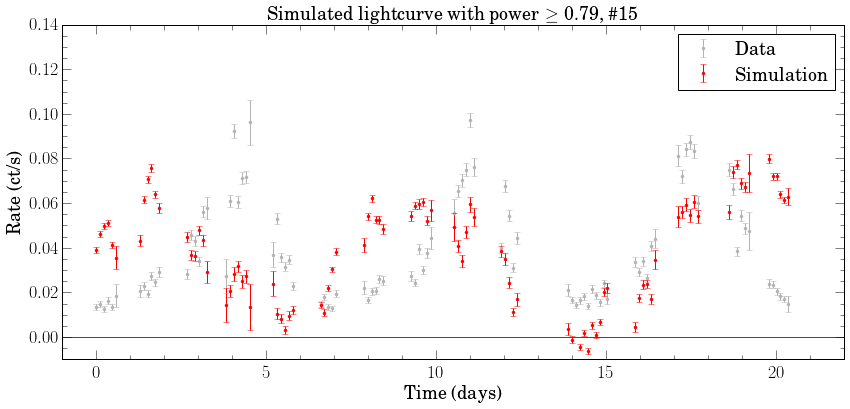

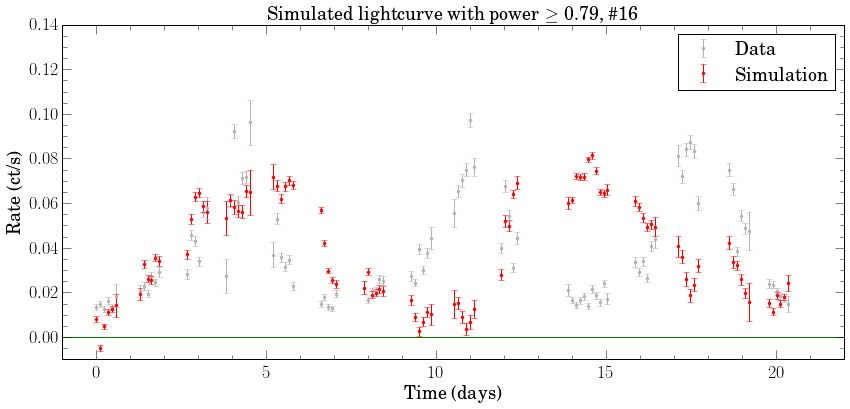

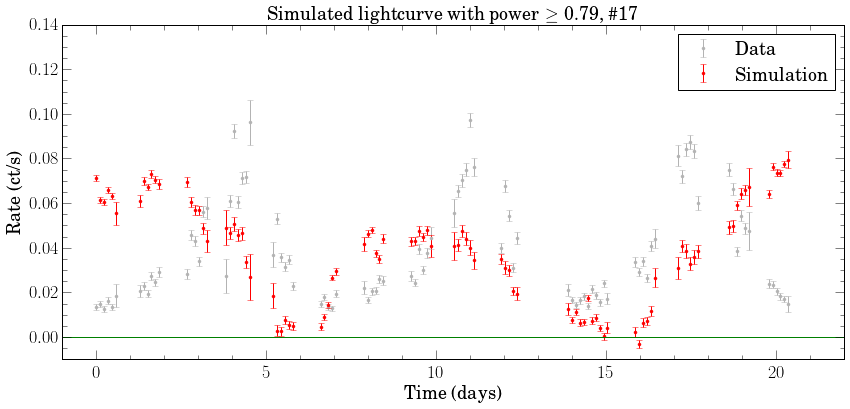

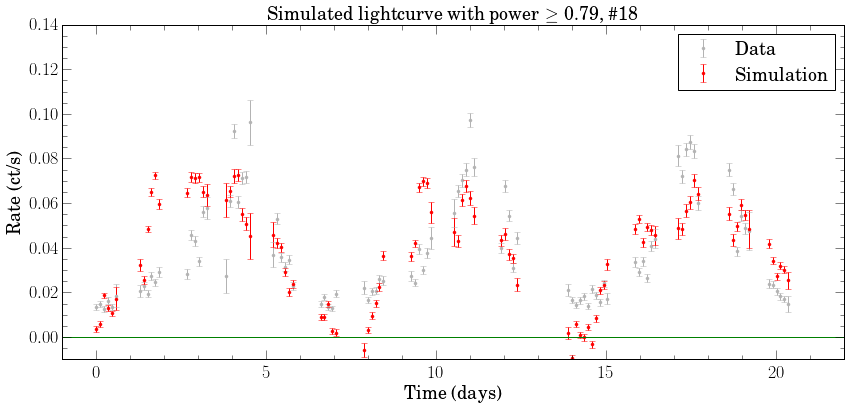

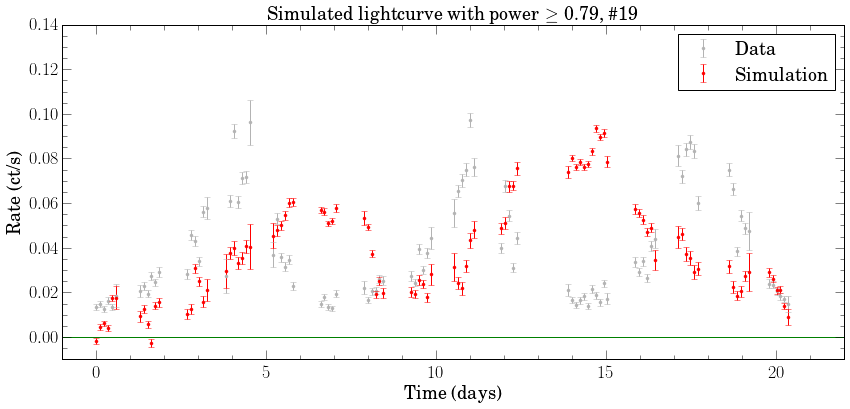

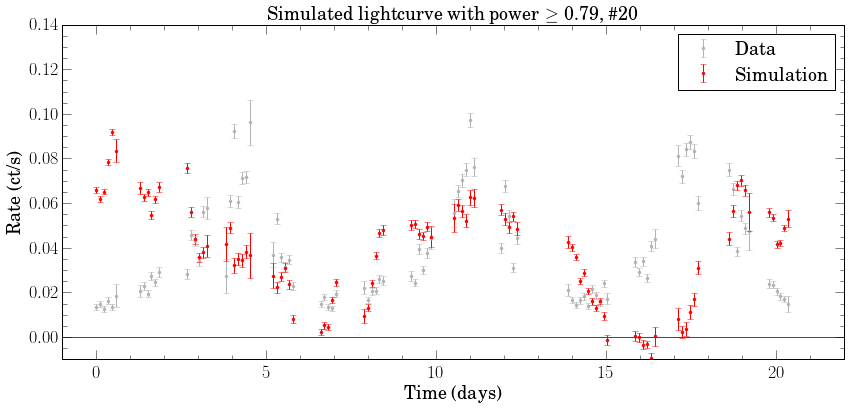

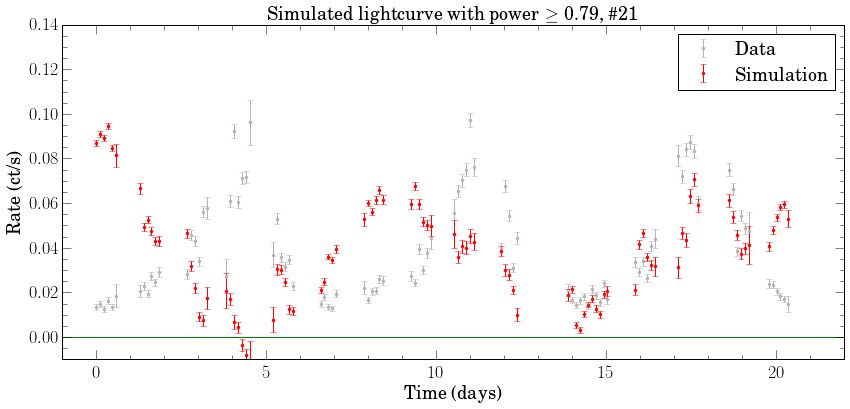

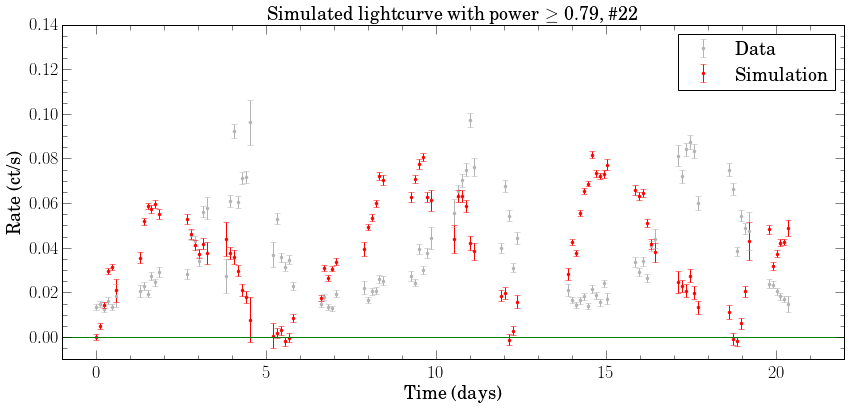

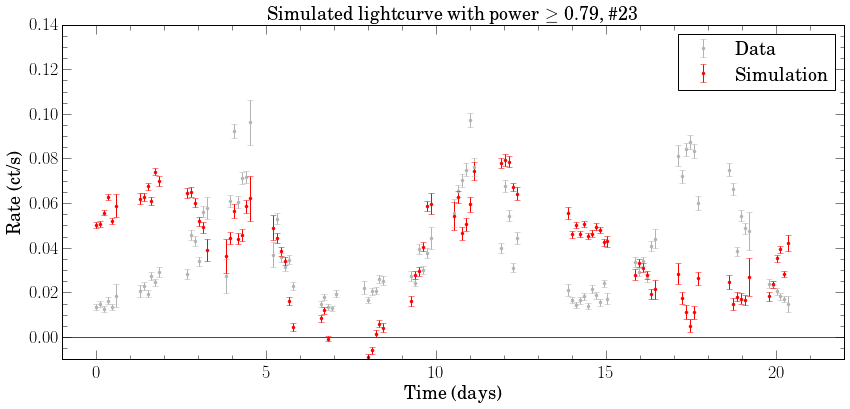

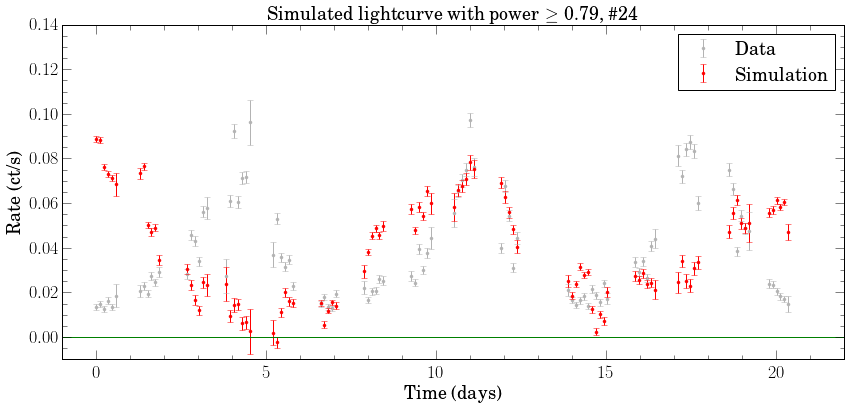

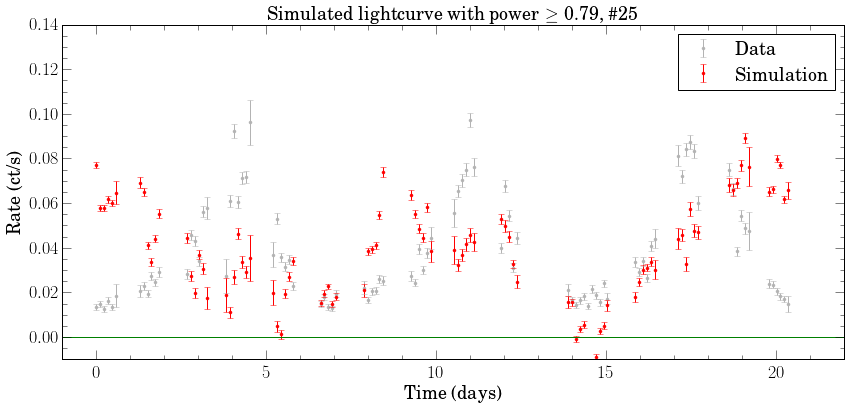

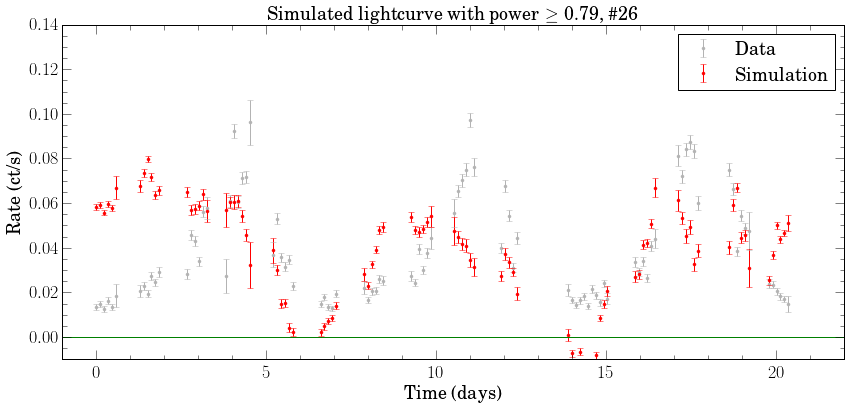

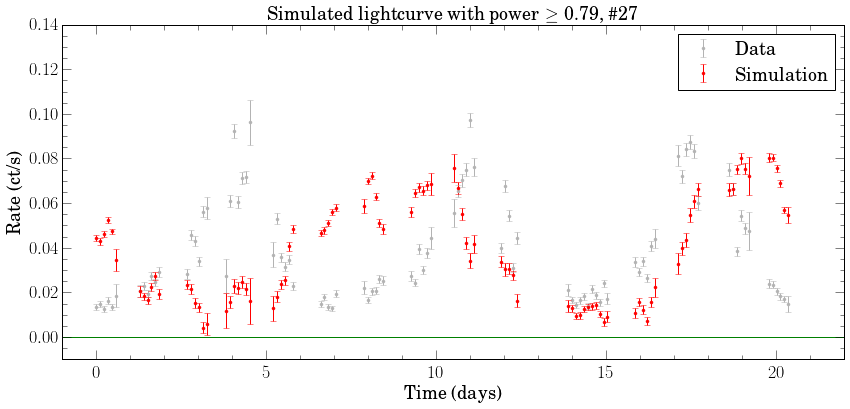

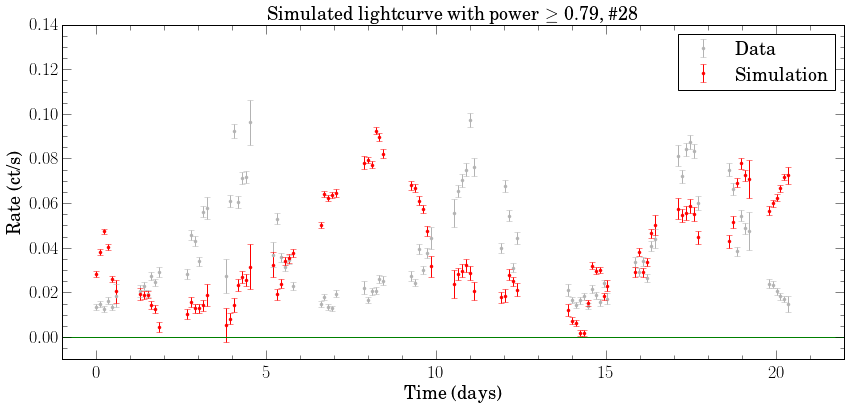

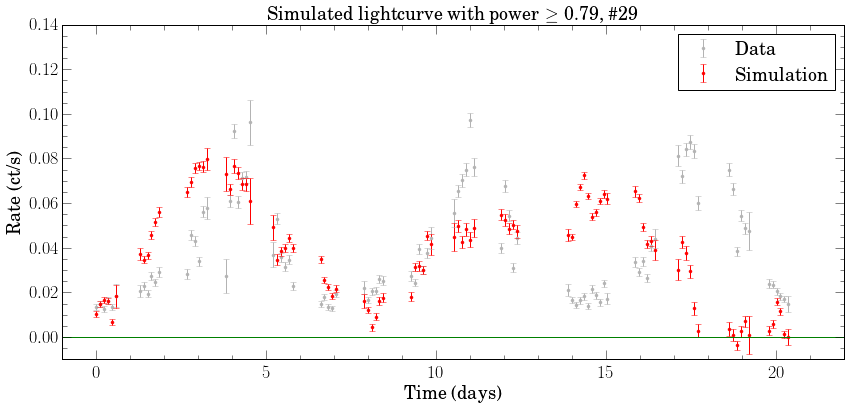

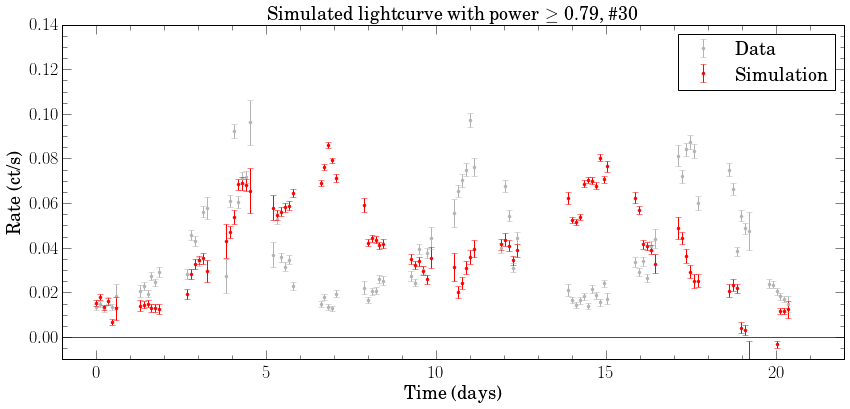

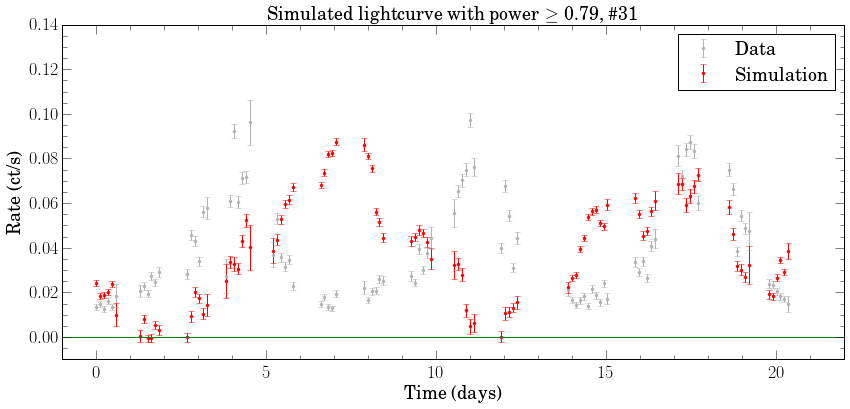

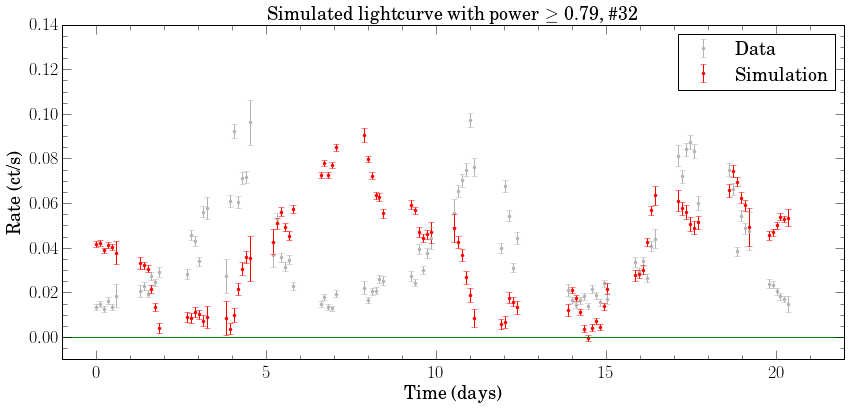

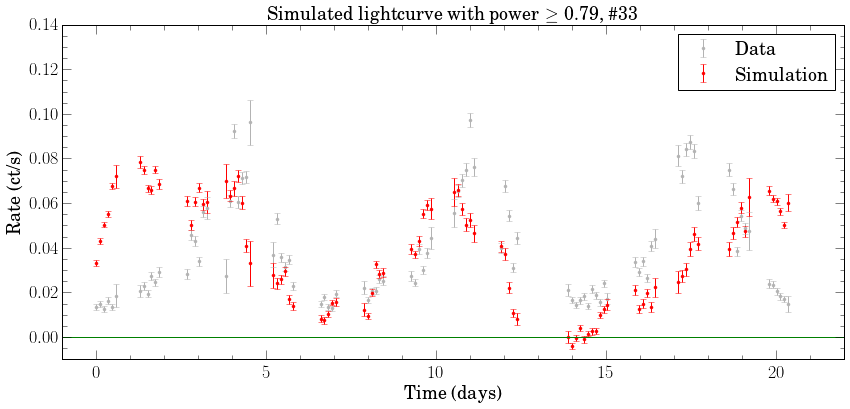

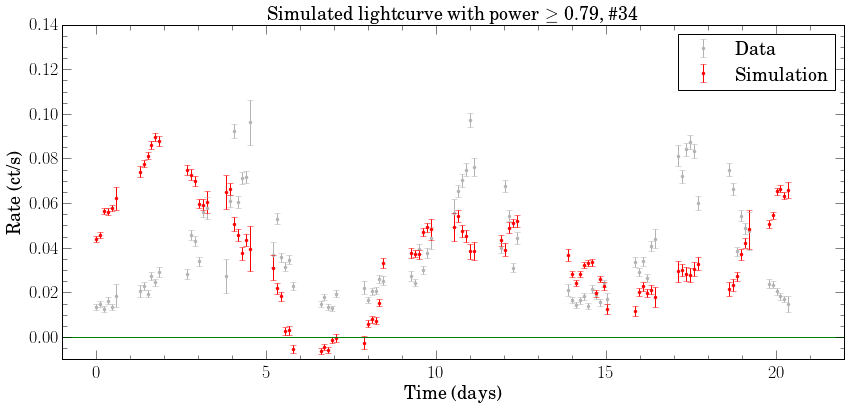

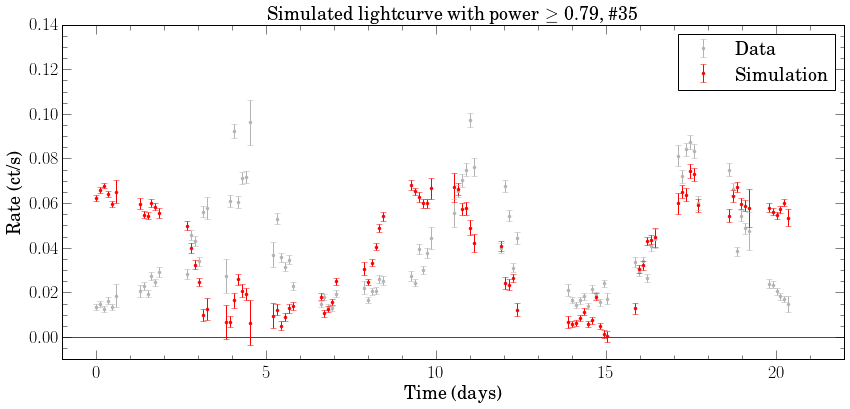

In [8]:
print 'Total number of simulated lightcurves:',len(max_pwr)
print 'Number of simulated lightcurves with peak power equal or greater than 0.79:',len(high_pwr_lcs)
for k in range(len(high_pwr_lcs)):
    plt.figure(figsize=(14,6))
    plt.title('Simulated lightcurve with power $\geq$ 0.79, \#'+str(k+1), fontsize=18)
    plt.errorbar(lc.time,lc.flux,lc.errors,fmt='.',color='0.7',label='Data')
    plt.errorbar(high_pwr_lcs[k].time, high_pwr_lcs[k].flux,y_er, fmt='.r', label='Simulation')
    plt.plot([-1,22],[0,0],'-g')
    plt.xlabel('Time (days)', fontsize=18)
    plt.ylabel('Rate (ct/s)', fontsize=18)
    plt.xlim(-1,22)
    plt.ylim(-0.01,0.14)
    plt.legend(numpoints=1,fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='major', length=9)
    plt.tick_params(axis='both', which='minor', length=4.5)
    plt.minorticks_on()

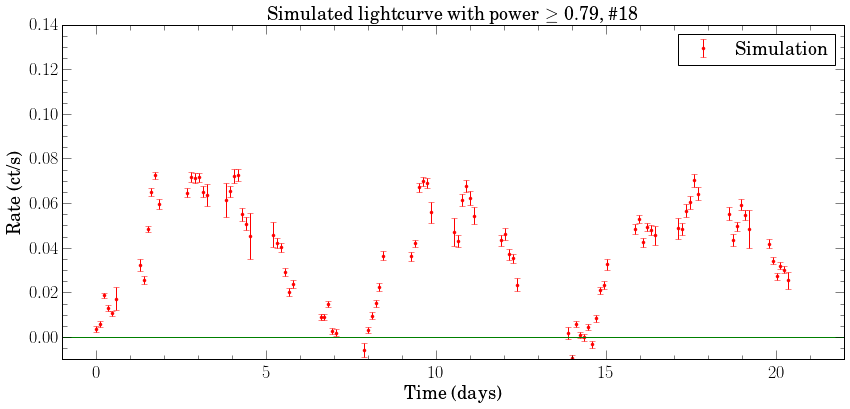

In [14]:
k = 17
plt.figure(figsize=(14,6))
plt.title('Simulated lightcurve with power $\geq$ 0.79, \#'+str(k+1), fontsize=18)
#plt.errorbar(lc.time,lc.flux,lc.errors,fmt='.',color='0.7',label='Data')
plt.errorbar(high_pwr_lcs[k].time, high_pwr_lcs[k].flux,y_er, fmt='.r', label='Simulation')
plt.plot([-1,22],[0,0],'-g')
plt.xlabel('Time (days)', fontsize=18)
plt.ylabel('Rate (ct/s)', fontsize=18)
plt.xlim(-1,22)
plt.ylim(-0.01,0.14)
plt.legend(numpoints=1,fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.minorticks_on()